In [1]:
# импортируем нужные библиотеки и модули
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

# вставляем графику в блокнот
%matplotlib inline

In [2]:
# загружаем геометрию из файла с данными
naca_filepath = os.path.join('MainFoil_N=100.csv')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, delimiter = ',', unpack=True)

naca_filepath = os.path.join('FlapFoil_N=100.csv')
with open(naca_filepath, 'r') as infile:
    x_1, y_1 = numpy.loadtxt(infile, dtype=float, delimiter = ',', unpack=True)
    

naca_filepath = os.path.join('Cp_Flap_theoretical.csv')    
with open(naca_filepath, 'r') as infile:
    x_orig, y_orig = numpy.loadtxt(infile, dtype=float, delimiter = ',', unpack=True)

naca_filepath = os.path.join('Cp_Main_theoretical.csv')
with open(naca_filepath, 'r') as infile:
    x_1_orig, y_1_orig = numpy.loadtxt(infile, dtype=float, delimiter = ',', unpack=True)

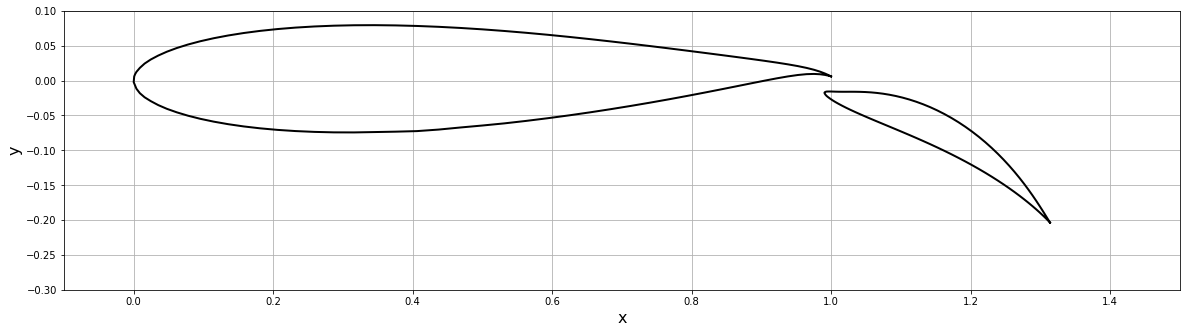

In [3]:
# рисуем геометрию
width = 20
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_1, y_1, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.1);

In [4]:
x_1.shape

(101,)

In [5]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
       
        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления

In [6]:
def define_panels(x, y, N):
    
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [7]:
# разбиваем геометрию на панели
N_m = len(x) - 1
N_f = len(x_1) - 1

panels_m = define_panels(x, y, N_m)
panels_f = define_panels(x_1, y_1, N_f)



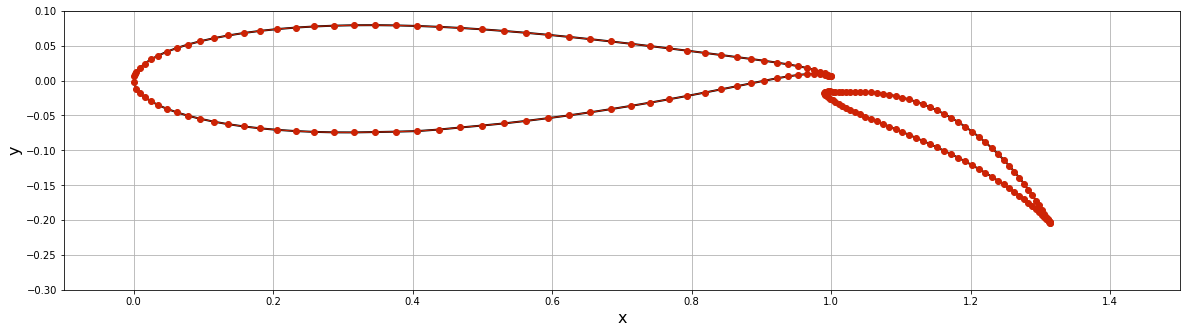

In [8]:
# рисуем дискретизированую геометрию
width = 20
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_1, y_1, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels_m], panels_m[0].xa),
            numpy.append([panel.ya for panel in panels_m], panels_m[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')
pyplot.plot(numpy.append([panel.xa for panel in panels_f], panels_f[0].xa),
            numpy.append([panel.ya for panel in panels_f], panels_f[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.1);

In [9]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [45]:
# задаем параметры набегающего потока
freestream = Freestream(u_inf=1.0, alpha=0)

In [46]:
def integral(x, y, panel, dxdk, dydk):
   
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


In [47]:
def source_contribution_normal(panels):
   
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # вклад рассматриваемой панели в общее поле источников
    numpy.fill_diagonal(A, 0.5)
    # вклад остальных панелей
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [48]:
def vortex_contribution_normal(panels):
   
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # вклад от рассматриваемой панели в поле вихря
    numpy.fill_diagonal(A, 0.0)
    # вихревой вклад от всех остальных панелей
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [49]:
A_source = source_contribution_normal(numpy.append(panels_m, panels_f))
B_vortex = vortex_contribution_normal(numpy.append(panels_m, panels_f))

In [50]:
def kutta_condition(A_source, B_vortex, N_m):
   
    b = numpy.empty(shape = (2, A_source.shape[0]+2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    b[0, :-2] = B_vortex[0, :] + B_vortex[N_m - 1, :]
    b[1, :-2] = B_vortex[N_m, :] + B_vortex[-1, :]
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    b[0, -2] = - numpy.sum(A_source[0, 0:N_m] + A_source[N_m - 1, 0:N_m])
    b[0, -1] = - numpy.sum(A_source[0, N_m:] + A_source[N_m - 1, N_m:])
    b[1, -2] = - numpy.sum(A_source[N_m, 0:N_m] + A_source[-1, 0:N_m])
    b[1, -1] = - numpy.sum(A_source[N_m, N_m:] + A_source[-1, N_m:])
    return b

In [51]:
def build_singularity_matrix(A_source, B_vortex, N_m):
   
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), \
                    dtype=float)
    # матрица источников
    A[:-2, :-2] = A_source
    # матрица вихрей
    A[:-2, -2] = numpy.sum(B_vortex[:, 0:N_m], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:, N_m:], axis=1)
    # условие Кутты-Жуковского
    A[-2:, :] = kutta_condition(A_source, B_vortex, N_m)
    return A

In [52]:
def build_freestream_rhs(panels_m, panels_f, freestream):
    
    b = numpy.empty(panels_m.size + panels_f.size + 2,dtype=float)
    # вклад от набегающего потока в каждую панель
    for i, panel in enumerate(numpy.append(panels_m, panels_f)):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # вклад от набегающего потока в условие Кутты-Жуковского
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels_m[0].beta)
                               +numpy.sin(freestream.alpha-panels_m[-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels_f[0].beta)
                               +numpy.sin(freestream.alpha-panels_f[-1].beta) )
    return b

In [53]:
A = build_singularity_matrix(A_source, B_vortex, panels_m.size)
b = build_freestream_rhs(panels_m, panels_f, freestream)

In [54]:
strengths = numpy.linalg.solve(A, b) 

In [55]:
for i , panel in enumerate(panels_m):
    panel.sigma = strengths[i]
for i , panel in enumerate(panels_f):
    panel.sigma = strengths[i+N_m]
gamma_m = strengths[-2]
gamma_f = strengths[-1]

In [56]:
def compute_tangential_velocity(panels_m, panels_f, freestream, gamma_m, gamma_f, A_source, B_vortex):
    
    N_m = panels_m.size
    A = numpy.empty( (N_m + panels_f.size, N_m + panels_f.size + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    A[:, -2] = -numpy.sum(A_source[:, 0:N_m], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, N_m:], axis=1)
    # добавляем набегающий поток
    panels = numpy.append(panels_m, panels_f)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], [gamma_m, gamma_f])
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [57]:
# касательная компонента скорости на каждой панели
compute_tangential_velocity(panels_m, panels_f, freestream, gamma_m, gamma_f, A_source, B_vortex)

In [58]:
def compute_pressure_coefficient(panels_m, panels_f, freestream):
 
    panels_common = numpy.append(panels_m, panels_f)
    
    for panel in panels_common:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [59]:
# коэффициент давления на поверхности
compute_pressure_coefficient(panels_m, panels_f, freestream)

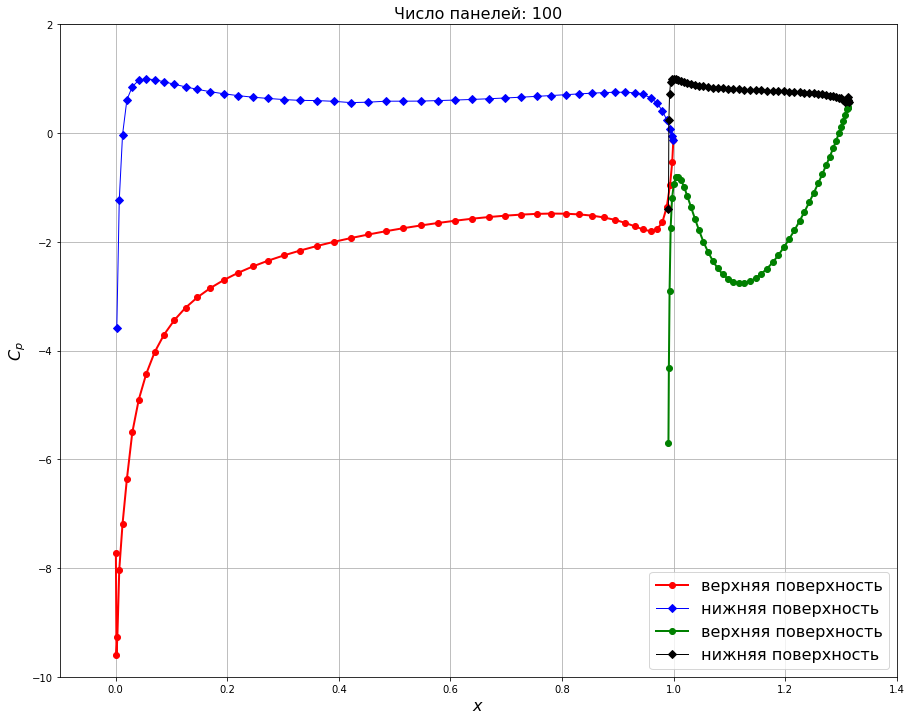

In [60]:
# рисуем коэффициент давления на поверхности
pyplot.figure(figsize=(15, 12))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels_m if panel.loc == 'upper'],
            [panel.cp for panel in panels_m if panel.loc == 'upper'],
            label='верхняя поверхность',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_m if panel.loc == 'lower'],
            [panel.cp for panel in panels_m if panel.loc == 'lower'],
            label= 'нижняя поверхность',
            color='b', linestyle='-', linewidth=1, marker='D', markersize=6)
pyplot.plot([panel.xc for panel in panels_f if panel.loc == 'upper'],
            [panel.cp for panel in panels_f if panel.loc == 'upper'],
            label='верхняя поверхность',
            color='g', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_f if panel.loc == 'lower'],
            [panel.cp for panel in panels_f if panel.loc == 'lower'],
            label= 'нижняя поверхность',
            color='k', linestyle='-', linewidth=1, marker='D', markersize=6)

pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-10, 2)
pyplot.title('Число панелей: {}'.format(panels_m.size), fontsize=16);

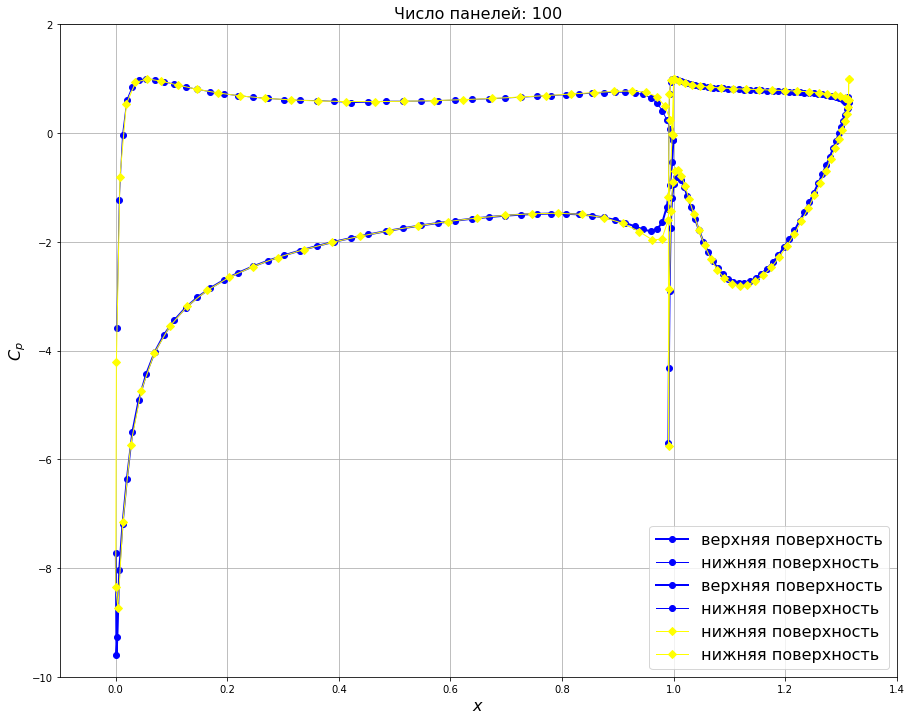

In [61]:
# рисуем коэффициент давления на поверхности
pyplot.figure(figsize=(15, 12))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels_m if panel.loc == 'upper'],
            [panel.cp for panel in panels_m if panel.loc == 'upper'],
            label='верхняя поверхность',
            color='b', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_m if panel.loc == 'lower'],
            [panel.cp for panel in panels_m if panel.loc == 'lower'],
            label= 'нижняя поверхность',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_f if panel.loc == 'upper'],
            [panel.cp for panel in panels_f if panel.loc == 'upper'],
            label='верхняя поверхность',
            color='b', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_f if panel.loc == 'lower'],
            [panel.cp for panel in panels_f if panel.loc == 'lower'],
            label= 'нижняя поверхность',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.plot(x_orig, y_orig,
            label= 'нижняя поверхность',
            color='yellow', linestyle='-', linewidth=1, marker='D', markersize=6)
pyplot.plot(x_1_orig, y_1_orig,
            label= 'нижняя поверхность',
            color='yellow', linestyle='-', linewidth=1, marker='D', markersize=6)

pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-10, 2)
pyplot.title('Число панелей: {}'.format(panels_m.size), fontsize=16);

In [62]:
# вычисляем точность
accuracy = sum([panel.sigma*panel.length for panel in panels_m]) + sum([panel.sigma*panel.length for panel in panels_f])
print('суммарная интенсивность особенностей: {:0.6f}'.format(accuracy))

суммарная интенсивность особенностей: -0.001748


In [65]:
F_x = 0
F_y = 0
for p in numpy.append(panels_m, panels_f):
    F_x += -p.cp*p.length*numpy.cos(p.beta)
    F_y += -p.cp*p.length*numpy.sin(p.beta)
    
    
l = abs(max(x) - min(x))
C_x = F_x/l
C_y = F_y

In [66]:
print(C_x, C_y)

-0.010793049185871626 3.6977144768607513


In [30]:
filepath = os.path.join('NACA23012_MainFoil.csv')
with open(filepath, 'r') as infile:
    x_m_new, y_m_new = numpy.loadtxt(infile, dtype=float, delimiter=',',unpack=True)

filepath_f = os.path.join('NACA23012_FlapFoil.csv')
with open(filepath_f, 'r') as infile:
    x_f, y_f = numpy.loadtxt(infile, dtype=float, delimiter=',',unpack=True)

In [31]:
z_f = x_f +1j*y_f
z_0 = 1.03-1j*0.054

z = (z_f - z_0)*numpy.exp(-20/180*numpy.pi*1j) + z_0

x_f_new = z.real
y_f_new = z.imag

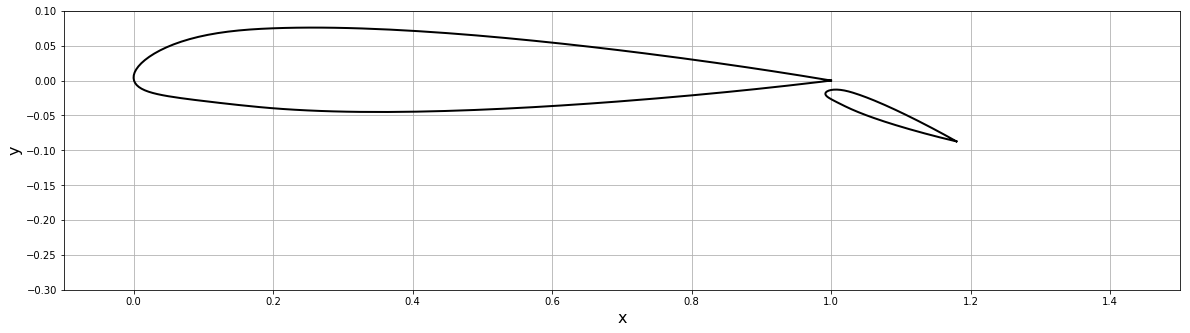

In [32]:
width = 20
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m_new, y_m_new, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_f_new, y_f_new, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.1);

In [42]:
def once_more (x_m, y_m, x_f, y_f, freestream):
    panels_m = define_panels(x_m, y_m, 150)
    panels_f = define_panels(x_f, y_f, 150)

    N_m = len(panels_m)
    N_f = len(panels_f)

    A_source = source_contribution_normal(numpy.append(panels_m, panels_f))
    B_vortex = vortex_contribution_normal(numpy.append(panels_m, panels_f))
    
    A = build_singularity_matrix(A_source, B_vortex, len(x_m) - 1)
    b = build_freestream_rhs(panels_m, panels_f, freestream)
    
    # рассчитываем интенсивности источников и вихря
    strengths = numpy.linalg.solve(A, b)    

    # заполняем интенсивности на кажой панели
    for i , panel in enumerate(panels_m):
        panel.sigma = strengths[i]
    for i , panel in enumerate(panels_f):
        panel.sigma = strengths[i+N_m]

    # запоминаем циркуляцию
    gamma_m = strengths[-2]
    gamma_f = strengths[-1]
    
    # касательная компонента скорости на каждой панели
    compute_tangential_velocity(panels_m, panels_f, freestream, gamma_m, gamma_f, A_source, B_vortex)
    
    # коэффициент давления на поверхности
    compute_pressure_coefficient(panels_m, panels_f, freestream)
    
    F_x = 0
    F_y = 0
    for p in numpy.append(panels_m, panels_f):
        F_x += -p.cp*p.length*numpy.cos(p.beta)
        F_y += -p.cp*p.length*numpy.sin(p.beta)


    l = abs(max(x_m) - min(x_m))
    #C_x = F_x/l*numpy.cos(freestream.alpha/180*numpy.pi) + F_y/l*numpy.sin(freestream.alpha/180*numpy.pi)
    C_y = F_y/l*numpy.cos(freestream.alpha/180*numpy.pi) - F_x/l*numpy.sin(freestream.alpha/180*numpy.pi)
    
    return C_y

In [43]:
angle = 20.0*numpy.pi/180 
freestream = Freestream(1, angle)
C_y = once_more(x_m_new, y_m_new, x_f_new, y_f_new, freestream)
    
C_y   

1.5679398664815865

In [44]:
angle_from = -14
angle_to = 14

x_c = 1.03
y_c = -0.054
eps = 0.01

N_m_new = len(x_m_new) - 1
N_f_new = len(x_f_new) - 1
             

panels_main = define_panels(x_m_new, y_m_new, N_m_new)
panels_flap = define_panels(x_f_new, y_f_new, N_f_new)


while abs(angle_from - angle_to) > eps:
    
    u_inf = 1
    angle_mid = (angle_from +angle_to)/2
    
    freestream = Freestream(1.0, angle_mid)
    C_y = once_more(x_m_new, y_m_new, x_f_new, y_f_new, freestream)
        
    print(C_y)
    if C_y > 0:
        angle_to = (angle_mid)/2
    else:
        angle_from = (angle_mid)/2
    print(" a =",angle_from, " b =",angle_to)

1.520186260526616
 a = -12  b = 0.0
0.6878918321308874
 a = -12  b = -3.0
0.4788567732351938
 a = -12  b = -3.75
0.4266905413014386
 a = -12  b = -3.9375
0.4136571494535443
 a = -12  b = -3.984375
0.41039934906388503
 a = -12  b = -3.99609375
0.4095849337706161
 a = -12  b = -3.9990234375
0.40938133213163236
 a = -12  b = -3.999755859375
0.40933043185854834
 a = -12  b = -3.99993896484375
0.40931770679882096
 a = -12  b = -3.9999847412109375
0.40931452553442105
 a = -12  b = -3.9999961853027344
0.40931373021835615
 a = -12  b = -3.9999990463256836
0.40931353138934057
 a = -12  b = -3.999999761581421
0.40931348168208925
 a = -12  b = -3.9999999403953552
0.4093134692552769
 a = -12  b = -3.999999985098839
0.4093134661485715
 a = -12  b = -3.9999999962747097
0.40931346537189467
 a = -12  b = -3.9999999990686774
0.40931346517772776
 a = -12  b = -3.9999999997671694
0.40931346512918565
 a = -12  b = -3.9999999999417923
0.4093134651170489
 a = -12  b = -3.999999999985448
0.40931346511401495


KeyboardInterrupt: 